### Import Python Modules:

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle

from collections import deque
from moviepy.editor import *
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# for scikit-learn <= 0.17 use:
# from sklearn.cross_validation import train_test_split

### Import Trained Classifier:

In [2]:
with open('./Model/svc_model_with_color_features.pkl', 'rb') as fid:
    svc = pickle.load(fid)
    
with open('./Model/X_scaler_with_color_features.pkl', 'rb') as fid:
    X_scaler = pickle.load(fid)

### Functions for the Pipeline:

In [3]:
# Color and HOG features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Sliding Window
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
#     print(xspan, yspan)
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


# Single image feature
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
    
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #6) Append features to list
        img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Search Window
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         print(img[window[0][1])
        
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Parameters:

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

orient = 9          # HOG orientations
pix_per_cell = 8    # HOG pixels per cell
cell_per_block = 2  # HOG cells per block

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16          # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True    # Histogram features on or off
hog_feat = True     # HOG features on or off

y_start_stop = [400, 700] # Min and max in y to search in slide_window()

### Pipeline:

In [5]:
def pipeline(test_img):
    heatmaps = []
    prev_heatmaps = []
    
    imported_img = test_img
    
    test_img = test_img.astype(np.float32)/255
#     print(test_img.shape[:]) 720, 1280

    windows1 = slide_window(test_img, x_start_stop=(768, 1280), y_start_stop=(400, 496),
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5))
    first_layer = draw_boxes(test_img, windows1, color=(0, 255, 255), thick=6)
    
    
    windows2 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 500), 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.5)) #0.85, 0.78
    second_layer = draw_boxes(test_img, windows2, color=(0, 0, 255), thick=6)

    
    windows3 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 600), 
                        xy_window=(128, 128), xy_overlap=(0.8, 0.5))  # 0.8,0.5
    third_layer = draw_boxes(test_img, windows3, color=(0, 255, 0), thick=6)

    
    windows4 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 700), 
                        xy_window=(256, 128), xy_overlap=(0, 0)) # 0.25, 0.25
    fourth_layer = draw_boxes(test_img, windows4, color=(255, 0, 0), thick=6)
    
    windows = windows1 + windows2 + windows3 + windows4



    # Total number of windows we are searching in the image
    print(len(windows))
    
    # Windows with detected car features
    hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Draw car detected windows
    window_img = draw_boxes(test_img, hot_windows, color=(0, 0, 255), thick=6)
        
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heatmaps.append(heat)
    heatmaps = (heatmaps + prev_heatmaps)
    heatmaps = sum(heatmaps)/len(heatmaps)
                    
    heat = apply_threshold(heat, 4)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(imported_img, labels)
    
    prev_heatmaps = heatmaps

    return first_layer, second_layer, third_layer, fourth_layer, window_img, heatmap, labels, draw_img

### Display the process for one image:

165


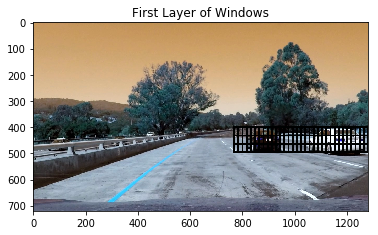

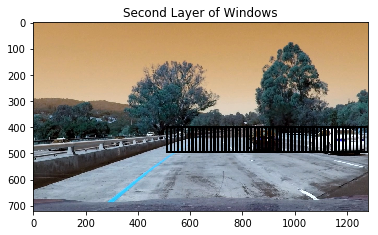

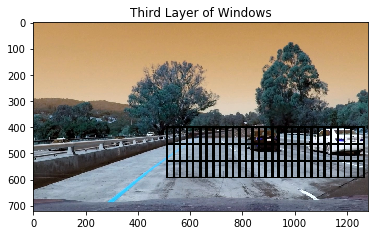

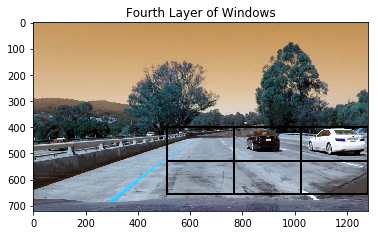

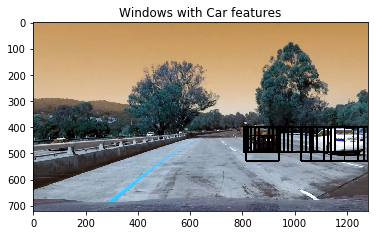

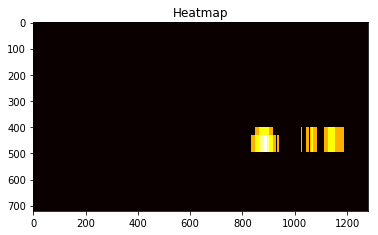

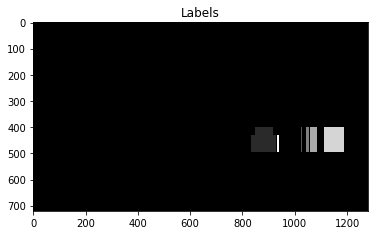

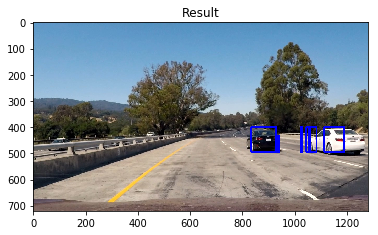

In [6]:
filename = './test_images/test1.jpg'
test_img = cv2.imread(filename)
    
first_layer, second_layer, third_layer, fourth_layer, window_img, heatmap, labels, result = pipeline(test_img)

plt.title('First Layer of Windows')
plt.imshow(first_layer)
plt.show()

plt.title('Second Layer of Windows')
plt.imshow(second_layer)
plt.show()

plt.title('Third Layer of Windows')
plt.imshow(third_layer)
plt.show()

plt.title('Fourth Layer of Windows')
plt.imshow(fourth_layer)
plt.show()

plt.title('Windows with Car features')
plt.imshow(window_img)
plt.show()

plt.title('Heatmap')
plt.imshow(heatmap, cmap='hot')
plt.show()

plt.title('Labels')
plt.imshow(labels[0], cmap='gray')
plt.show()

plt.title('Result')
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()

### Run the pipeline on multiple images:

165


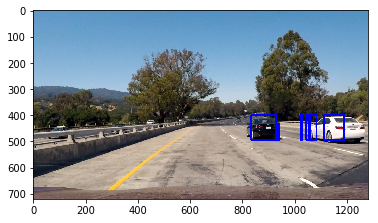

165


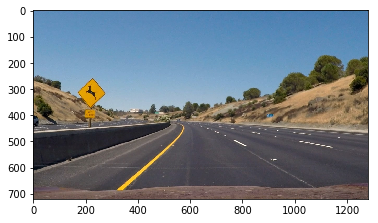

165


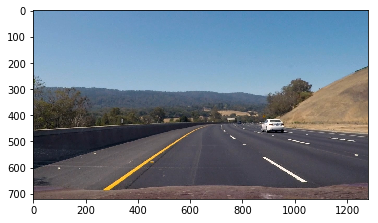

165


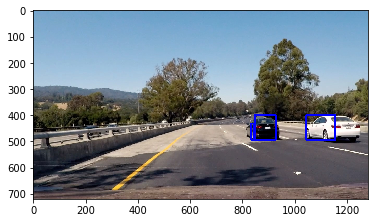

165


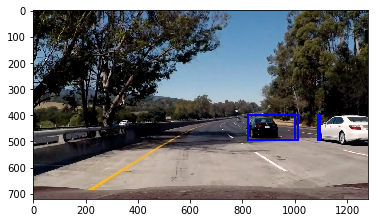

165


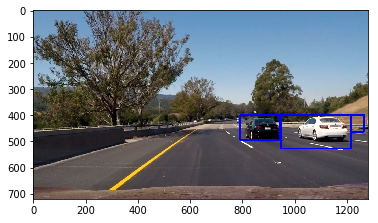

In [7]:
count = 0
heatmap_images = glob.glob('./test_images/*.JPG')

for fname in heatmap_images:
    count += 1
    test_img = cv2.imread(fname)
    
    first_layer, second_layer, third_layer, fourth_layer, window_img, heatmap, labels, result = pipeline(test_img)
#     filename = './output_images/test' + str(count) + '.jpg'
#     cv2.imwrite(filename, result)


    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    plt.imshow(result, cmap='gray')
    plt.show()

### Video Implementation:

In [8]:
def video_pipeline(test_img):
    heatmaps = []
    prev_heatmaps = []
    
    imported_img = test_img
    
    test_img = test_img.astype(np.float32)/255
    
    windows1 = slide_window(test_img, x_start_stop=(768, 1280), y_start_stop=(400, 496),
                    xy_window=(64, 64), xy_overlap=(0.85, 0.5))
    first_layer = draw_boxes(test_img, windows1, color=(0, 255, 255), thick=6)
    
    
    windows2 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 500), 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.5)) #0.85, 0.78
    second_layer = draw_boxes(test_img, windows2, color=(0, 0, 255), thick=6)

    
    windows3 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 600), 
                        xy_window=(128, 128), xy_overlap=(0.8, 0.5))  # 0.8,0.5
    third_layer = draw_boxes(test_img, windows3, color=(0, 255, 0), thick=6)

    
    windows4 = slide_window(test_img, x_start_stop=(512, test_img.shape[1]), y_start_stop=(400, 700), 
                        xy_window=(256, 128), xy_overlap=(0, 0)) # 0.25, 0.25
    fourth_layer = draw_boxes(test_img, windows4, color=(255, 0, 0), thick=6)
    
    windows = windows1 + windows2 + windows3 + windows4

    # Total number of windows we are searching in the image
#     print(len(windows))
    
    # Windows with detected car features
    hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw car detected windows
    window_img = draw_boxes(test_img, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heatmaps.append(heat)
    heatmaps = (heatmaps + prev_heatmaps)
    heatmaps = sum(heatmaps)/len(heatmaps)
                    
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(imported_img, labels)
    
    prev_heatmaps = heatmaps

    return draw_img

In [9]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('.//project_video.mp4')
# clip1 = clip1.subclip(18, 28)
white_clip = clip1.fl_image(video_pipeline)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [35:59<00:01,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

